In [9]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/lazartomi/ens-dRMS.git

Cloning into 'ens-dRMS'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 147 (delta 0), reused 0 (delta 0), pack-reused 146
Receiving objects: 100% (147/147), 18.81 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [10]:
def calc_dist(line, line2):
	d = 0.0
	x1 = float(line[29:38])
	x2 = float(line2[29:38])
	y1 = float(line[38:46])
	y2 = float(line2[38:46])
	z1 = float(line[46:54])
	z2 = float(line2[46:54])

	d = np.sqrt( np.square(x1-x2)+np.square(y1-y2)+np.square(z1-z2) )
	return d;



def dist_distrib(ens_type, data_folder, res_folder, ensemble_file, \
             atomtype, first_res, last_res):
  myhash={}
  infile = open(data_folder+ensemble_file, 'r')
  lines = []
  for line0 in infile:
    if line0[0:4] == "ATOM" or line0[0:6] == "HETATM":
      if line0[13:16].strip() == 'CA':
        lines.append(line0)
  infile.close()

  mod_num = 1
  for line in lines:
    line = line.strip()
    j = int(line[22:26])
    if line[13:16].strip() == atomtype:
      lines2 = lines
      mod_num2 = 1
      for line2 in lines2:
        line2 = line2.strip()
        k = int(line2[22:26])
        if k > j:
          if line2[13:16].strip() == atomtype:
            if mod_num == mod_num2:
              mydist = calc_dist(line, line2)
              pair = (j,k)
              mylist = []
              if pair in myhash:
                mylist = myhash[pair]
              mylist.append(mydist)
              myhash[pair] = mylist
            if k == last_res:
              mod_num2 += 1
      if j == last_res:
        mod_num += 1

  outfile = open(res_folder+ensemble_file[0:-4]+"_"+atomtype+"_distance_distributions.txt", 'w')
  matrix = np.empty((last_res-first_res+1, last_res-first_res+1))
  matrix.fill(0.0)
  for j in range(first_res, last_res):
    for k in range(j, last_res+1):
      if j == k:
        matrix[j-first_res][k-first_res] = 0.0
      else:
        pair = (j,k)
        if pair in myhash.keys():
          outfile.write(str(j)+";"+str(k)+";"+str(myhash[pair])+"\n")
          matrix[j-first_res][k-first_res] = np.median( myhash[pair] )
          matrix[k-first_res][j-first_res] = np.std( myhash[pair] )
        else:
          print(j, k, "-> no distribution recorded")
  outfile.close()
  plt.imshow(matrix, cmap='CMRmap_r', interpolation='None', extent=[first_res,last_res,last_res,first_res])
  plt.suptitle(ensemble_file[0:-4]+" "+atomtype+" distance matrix with st.dev", fontsize=18)
  plt.title('top: median,  bottom: st.dev', fontsize=12)
  plt.xlabel('residue number')
  plt.ylabel('residue number')
  plt.colorbar()
  plt.savefig(res_folder+ensemble_file[0:-4]+"_"+atomtype+"_ensemble_dist_heatmap_w_std.png", dpi=600)
  return


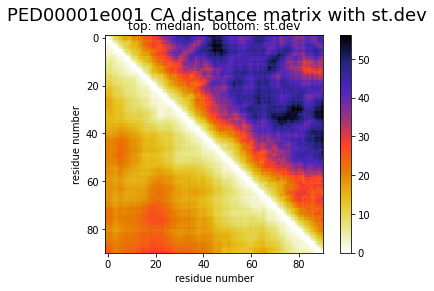

In [12]:
ens_type = "ensemble" # "ensemble" or "random_pool"
data_folder = "ens-dRMS/data/"+ens_type+"/"
res_folder = "./"
ensemble_file = "PED00001e001.pdb"
atomtype = "CA"
first_res = -1
last_res = 90
dist_distrib(ens_type, data_folder, res_folder, ensemble_file, \
             atomtype, first_res, last_res)

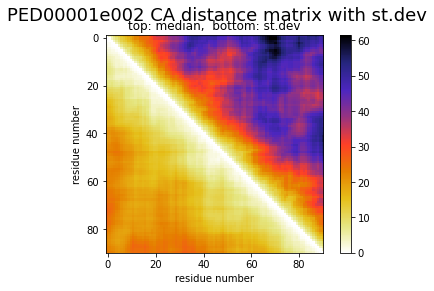

In [11]:
ens_type = "ensemble" # "ensemble" or "random_pool"
data_folder = "ens-dRMS/data/"+ens_type+"/"
res_folder = "./"
ensemble_file = "PED00001e002.pdb"
atomtype = "CA"
first_res = -1
last_res = 90
dist_distrib(ens_type, data_folder, res_folder, ensemble_file, \
             atomtype, first_res, last_res)

In [15]:
def read_distr(filename):
	myhash = {}
	infile = open(filename, 'r')
	for line in infile:
		line = line.strip()
		if len(line)>1:
			array = line.split(";")
			pair = ( int(array[0]), int(array[1]) )
			numbers = array[2][1:-1]
			number_array = numbers.split(", ")
			num_array = []
			for i in number_array:
				num_array.append(float(i))
			myhash[pair] = num_array
	infile.close()
	return myhash


def distrib_diff(filename1, filename2, outfilename, \
             atomtype, first_res, last_res):
  myhash = read_distr(filename1)
  myhash2 = read_distr(filename2)

  outfile = open(outfilename, 'w')
  for j in range(first_res, last_res):
    for k in range(j, last_res+1):
      if j == k:
        outfile.write(str(j)+";"+str(k)+";1.0;0.0;0.0;0.0\n")
      else:
        pair = (j,k)
        median_diff = abs( np.median(myhash[pair])-np.median(myhash2[pair]) )
        std_diff = abs( np.std(myhash[pair])-np.std(myhash2[pair]) )
        bigger = np.median(myhash[pair])
        if np.median(myhash2[pair]) > bigger:
          bigger = np.median(myhash2[pair])
        median_diff_perc = abs( np.median(myhash[pair])-np.median(myhash2[pair]) ) / bigger *100
        u, p_val = stat.mannwhitneyu(myhash[pair], myhash2[pair])
        outfile.write(str(j)+";"+str(k)+";"+str( p_val )+";"+str( median_diff )+";"+str( std_diff )+";"+str( median_diff_perc )+"\n")
  outfile.close()
  return


In [16]:
ensemble = "PED00001e001"
ensemble2 = "PED00001e002"
atomtype = "CA"
first_res = -1
last_res = 90
filename1 = ensemble+"_"+atomtype+"_distance_distributions.txt"
filename2 = ensemble2+"_"+atomtype+"_distance_distributions.txt"
outfilename = ensemble+"-"+ensemble2+"_"+atomtype+"_dist_distrib_differences.txt"

distrib_diff(filename1, filename2, outfilename, \
             atomtype, first_res, last_res)

In [31]:
def ens_dRMS(ensemble, ensemble2, atomtype, first_res, last_res):

  myhash_median_diff = {}
  myhash_median_diff_perc = {}
  myhash_median_diff_signif = {}
  myhash_median_diff_perc_signif = {}
  myhash_std_diff = {}

  sum_d_squared = 0.0
  sum_d_squared_all = 0.0
  infilename = ensemble+"-"+ensemble2+"_"+atomtype+"_dist_distrib_differences.txt"
  infile = open(infilename, 'r')
  for line in infile:
    line = line.strip()
    if len(line)>1:
      array = line.split(";")
      pair = ( int(array[0]), int(array[1]) )
      p_val = float( array[2] )
      median_diff = float( array[3] )
      std_diff = float( array[4] )
      median_diff_perc = float( array[5] )
      #median
      mylist = []
      if pair in myhash_median_diff.keys():
        mylist = myhash_median_diff[pair]
      mylist.append(median_diff)
      myhash_median_diff[pair] = mylist
      #median_signif
      mylist = []
      if pair in myhash_median_diff_signif.keys():
        mylist = myhash_median_diff_signif[pair]
      if p_val <= 0.05:
        mylist.append(median_diff)
      else:
        mylist.append(0.0)
      myhash_median_diff_signif[pair] = mylist
      #std
      mylist = []
      if pair in myhash_std_diff.keys():
        mylist = myhash_std_diff[pair]
      mylist.append(std_diff)
      myhash_std_diff[pair] = mylist
      #median diff perc
      mylist = []
      if pair in myhash_median_diff_perc.keys():
        mylist = myhash_median_diff_perc[pair]
      mylist.append(median_diff_perc)
      myhash_median_diff_perc[pair] = mylist
      #median diff perc signif
      mylist = []
      if pair in myhash_median_diff_perc_signif.keys():
        mylist = myhash_median_diff_perc_signif[pair]
      if p_val <= 0.05:
        mylist.append(median_diff_perc)
      else:
        mylist.append(0.0)
      myhash_median_diff_perc_signif[pair] = mylist
      #ensRMSD
      sum_d_squared_all += np.square( median_diff )
      if p_val <= 0.05:
        sum_d_squared += np.square( median_diff )
  infile.close()
  N = last_res+1-first_res
  Npairs = N*(N-1)/2
  ens_dRMS = np.sqrt(sum_d_squared / Npairs)
  print("ens-dRMS = "+str(ens_dRMS)+" A     (masked)")
  ens_dRMS_all = np.sqrt(sum_d_squared_all / Npairs)
  print("ens-dRMS = "+str(ens_dRMS_all)+" A     (unmasked - not recommended)")

  return myhash_median_diff, myhash_std_diff, myhash_median_diff_signif, \
         myhash_median_diff_perc, myhash_median_diff_perc_signif, \
         ens_dRMS_all, ens_dRMS


In [72]:
def plot_unmasked(ensemble, ensemble2, atomtype, first_res, last_res, \
                  myhash_median_diff, myhash_std_diff, myhash_median_diff_perc):
  matrix = np.empty((last_res-first_res+1, last_res-first_res+1))
  matrix.fill(0.0)
  for j in range(first_res, last_res):
    for k in range(j, last_res+1):
      if j == k:
        matrix[j-first_res][k-first_res] = 0.0
      else:
        pair = (j,k)
        matrix[j-first_res][k-first_res] = np.mean(myhash_median_diff[pair] )
        matrix[k-first_res][j-first_res] = np.mean(myhash_std_diff[pair] ) 


  plt.imshow(matrix, cmap='CMRmap_r', interpolation='None', extent=[first_res,last_res,last_res,first_res])
  plt.suptitle("Difference matrix with median & st.dev", fontsize=18)
  plt.title('top: d(median),  bottom: d(st.dev)', fontsize=12)
  plt.xlabel('residue number')
  plt.ylabel('residue number')
  plt.colorbar()
  plt.savefig(ensemble+"-"+ensemble2+"_"+atomtype+"_diff_heatmap_w_median_std_wo_test.png", dpi=600) ## PED7AAC-ntail_pool_files/PED7AAC-ntail_pool...


  matrix = np.empty((last_res-first_res+1, last_res-first_res+1))
  matrix.fill(0.0)
  for j in range(first_res, last_res):
    for k in range(j, last_res+1):
      if j == k:
        matrix[j-first_res][k-first_res] = 0.0
      else:
        pair = (j,k)
        matrix[j-first_res][k-first_res] = np.mean(myhash_median_diff_perc[pair] )
        matrix[k-first_res][j-first_res] = np.mean(myhash_std_diff[pair] ) 


  plt.imshow(matrix, cmap='CMRmap_r', interpolation='None', extent=[first_res,last_res,last_res,first_res])
  plt.suptitle("Normalized difference matrix", fontsize=18) 
  plt.title('top: %d(median),  bottom: d(st.dev)', fontsize=12)
  plt.xlabel('residue number')
  plt.ylabel('residue number')
  plt.colorbar()
  plt.savefig(ensemble+"-"+ensemble2+"_"+atomtype+"_diff_heatmap_w_median_perc_std_wo_test.png", dpi=600) # PED6AAC-k18_pool_files/PED6AAC-k18_pool...
  return

In [32]:
ensemble = "PED00001e001"
ensemble2 = "PED00001e002"
atomtype = "CA"
first_res = -1
last_res = 90

myhash_median_diff, myhash_std_diff, myhash_median_diff_signif, \
         myhash_median_diff_perc, myhash_median_diff_perc_signif, \
         ens_dRMS, ens_dRMS_masked \
         = ens_dRMS(ensemble, ensemble2, atomtype, first_res, last_res)
#print(ens_dRMS, ens_dRMS_masked)

ens-dRMS = 0.2672538663544576 A     (masked)
ens-dRMS = 5.503211783273051 A     (unmasked - not recommended)


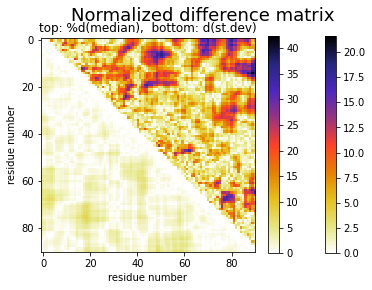

In [71]:
plot_unmasked(ensemble, ensemble2, atomtype, first_res, last_res, \
              myhash_median_diff, myhash_std_diff, myhash_median_diff_perc)
# 2 plots are generated, only the normalized is displayed for brevity

In [73]:
def plot_masked(ensemble, ensemble2, atomtype, first_res, last_res, \
                myhash_median_diff_signif, myhash_std_diff, myhash_median_diff_perc_signif):
  matrix = np.empty((last_res-first_res+1, last_res-first_res+1))
  matrix.fill(0.0)
  for j in range(first_res, last_res):
    for k in range(j, last_res+1):
      if j == k:
        matrix[j-first_res][k-first_res] = 0.0
      else:
        pair = (j,k)
        matrix[j-first_res][k-first_res] = np.mean(myhash_median_diff_signif[pair] )
        matrix[k-first_res][j-first_res] = np.mean(myhash_std_diff[pair] ) 


  plt.imshow(matrix, cmap='CMRmap_r', interpolation='None', extent=[first_res,last_res,last_res,first_res])
  plt.suptitle("Difference matrix with median & st.dev - Masked", fontsize=18)
  plt.title('top: d(median),  bottom: d(st.dev)', fontsize=12)
  plt.xlabel('residue number')
  plt.ylabel('residue number')
  plt.colorbar()
  plt.savefig(ensemble+"-"+ensemble2+"_"+atomtype+"_diff_heatmap_w_median_std.png", dpi=600) ## PED7AAC-ntail_pool_files/PED7AAC-ntail_pool...


  matrix = np.empty((last_res-first_res+1, last_res-first_res+1))
  matrix.fill(0.0)
  for j in range(first_res, last_res):
    for k in range(j, last_res+1):
      if j == k:
        matrix[j-first_res][k-first_res] = 0.0
      else:
        pair = (j,k)
        matrix[j-first_res][k-first_res] = np.mean(myhash_median_diff_perc_signif[pair] )
        matrix[k-first_res][j-first_res] = np.mean(myhash_std_diff[pair] ) 


  plt.imshow(matrix, cmap='CMRmap_r', interpolation='None', extent=[first_res,last_res,last_res,first_res])
  plt.suptitle("Normalized difference matrix - Masked", fontsize=18)
  plt.title('top: %d(median),  bottom: d(st.dev)', fontsize=12)
  plt.xlabel('residue number')
  plt.ylabel('residue number')
  plt.colorbar()
  plt.savefig(ensemble+"-"+ensemble2+"_"+atomtype+"_diff_heatmap_w_median_perc_std.png", dpi=600)
  return

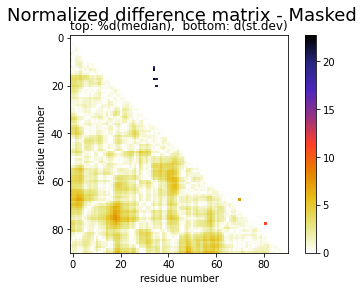

In [40]:
plot_masked(ensemble, ensemble2, atomtype, first_res, last_res, \
              myhash_median_diff_signif, myhash_std_diff, myhash_median_diff_perc_signif)
# 2 plots are generated, only the normalized is displayed for brevity

In [41]:
def calc_Rg_distr(filename, Npairs_res, name):
	myhash = {}
	infile = open(filename, 'r')
	for line in infile:
		line = line.strip()
		if len(line)>1:
			array = line.split(";")
			pair = ( int(array[0]), int(array[1]) )
			numbers = array[2][1:-1]
			number_array = numbers.split(", ")
			num_array = []
			for i in number_array:
				num_array.append(float(i))
			if pair in myhash.keys():
				myhash[pair] += num_array
			else:
				myhash[pair] = num_array
	infile.close()

	n_conf = len(myhash[(1,2)])
	Npairs_conf = (n_conf*(n_conf-1))/2
	Rgs = []
	for c in range(0,n_conf):
		dist_jk = 0
		for j in range(1,last_res ):
			for k in range(j+1, last_res+1):
				dist_jk += ( myhash[(j,k)][c]**2 )
		Rg = np.sqrt( dist_jk / Npairs_res )
		Rgs.append(Rg)
	print(name+":  <Rg>="+str(np.mean(Rgs))+" A")
	return Rgs

In [47]:
def plot_Rg_diff(Rg_array1, Rg_array2):
  p = stat.mannwhitneyu(Rg_array1, Rg_array2)[1]
  p = "%.2E" % p
  p1 = plt.hist(Rg_array1, bins=8, histtype='stepfilled', \
                alpha=0.5, density=True, color='r')
  p2 = plt.hist(Rg_array2, bins=8, histtype='stepfilled', \
                alpha=0.35, density=True, color='b')
  plt.suptitle("Rg distributions of "+ensemble+" & "+ensemble2)
  plt.title("Difference(U-test):  p="+p, fontsize=10)
  plt.xlabel("Rg (Angstrom)")
  plt.ylabel("density")
  plt.legend((ensemble, ensemble2), fontsize=12)
  plt.savefig("Rg_"+ensemble+"-"+ensemble2+".png", dpi=600)
  return

In [42]:
ensemble = "PED00001e001"
ensemble2 = "PED00001e002"
atomtype = "CA"
first_res = -1
last_res = 90

Npairs_res = (last_res*(last_res-1))/2
filename1 = ensemble+"_"+atomtype+"_distance_distributions.txt"
filename2 = ensemble2+"_"+atomtype+"_distance_distributions.txt"
Rg_array1 = calc_Rg_distr(filename1, Npairs_res, ensemble)
Rg_array2 = calc_Rg_distr(filename2, Npairs_res, ensemble2)

PED00001e001:  <Rg>=37.82878303351681 A
PED00001e002:  <Rg>=37.59466792235451 A


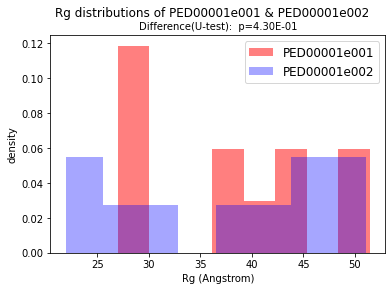

In [48]:
plot_Rg_diff(Rg_array1, Rg_array2)

In [51]:
!pip install Bio

     |████████████████████████████████| 269 kB 4.1 MB/s 
     |████████████████████████████████| 2.3 MB 49.0 MB/s 


In [67]:
import Bio.PDB

def local_superposition(ens_type, data_folder, ensemble_file, \
                        first_res, last_res):
  super_imposer = Bio.PDB.Superimposer()
  structure = Bio.PDB.PDBParser(QUIET=True).get_structure(ensemble_file[0:-4], data_folder+ensemble_file)
  prot_length = last_res - first_res

  outfilename = ensemble_file[0:-4]+"_local_rmsd_5aa.txt"
  outfile = open(outfilename, 'w')
  for i in range(first_res, prot_length+1-5 ):
    rmsd_array = []
    ref_model = structure[0]
    ref_atoms = []
    for ref_chain in ref_model:
      for ref_res in ref_chain:
        if ref_res.get_id()[1] >= i and ref_res.get_id()[1] < i+5:
          ref_atoms.append(ref_res['CA'])
          ref_atoms.append(ref_res['N'])
          ref_atoms.append(ref_res['C'])
          if 'O' in ref_res:
            ref_atoms.append(ref_res['O'])

    for j in range(1,len(structure)):
      #Build paired lists of c-alpha atoms, ref_atoms and alt_atoms
      alt_atoms = []
      for alt_chain in structure[j]:
        for alt_res in alt_chain :
          if alt_res.get_id()[1] >= i and alt_res.get_id()[1] < i+5:
            alt_atoms.append(alt_res['CA'])              
            alt_atoms.append(alt_res['N'])               
            alt_atoms.append(alt_res['C']) 
            if 'O' in alt_res:
              alt_atoms.append(alt_res['O'])

      #Align these paired atom lists:
      super_imposer.set_atoms(ref_atoms, alt_atoms)
      rmsd_array.append( super_imposer.rms )

    outfile.write(str(i)+";"+str(i+5-1)+";"+str(rmsd_array)+"\n")

  outfile.close()
  return

In [61]:
def plot_local_superposition(outfilename, ensemble_file, first_res, last_res):
  infile = open(outfilename, 'r')
  medians = []
  uppers = []
  lowers = []
  stdevs = []
  for line in infile:
    line = line.strip()
    if len(line)>1:
      array = line.split(";")
      rmsd_array = array[2][1:-1].split(", ")
      array2 = []
      for rmsd in rmsd_array:
        array2.append( float(rmsd) )
      rmsd_array = array2
      medians.append( np.median(rmsd_array) )
      stdevs.append( np.std(rmsd_array) )
      uppers.append( np.percentile(rmsd_array, 95) )
      lowers.append( np.percentile(rmsd_array, 5) )
  infile.close()

  x_pos = np.arange(first_res, last_res+1+1-5)
  ax = plt.subplot(1,1,1)
  plt.fill_between(x_pos, uppers, lowers, color='gray', alpha=0.6)
  plt.plot(x_pos, medians, 'k', label="medians")
  plt.plot(x_pos, uppers, 'gray', label="95% percentiles")
  plt.xlim(first_res, last_res)
  plt.ylim(0, 6)
  plt.title("Local superimposability of "+ensemble_file[0:-4])
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels)
  plt.xlabel("residue number")
  plt.ylabel("5-residue local backbone RMSD (Angstrom)")
  plt.savefig(ensemble_file[0:-4]+"_local_rmsd_5aa.png", dpi=600)
  return

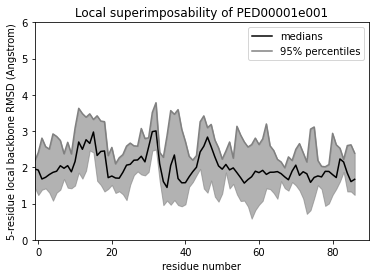

In [74]:
ens_type = "ensemble" # "ensemble" or "random_pool"
data_folder = "ens-dRMS/data/"+ens_type+"/"
ensemble_file = "PED00001e001.pdb"
filename = ensemble_file[0:-4]+"_local_rmsd_5aa.txt"
first_res = -1
last_res = 90

local_superposition(ens_type, data_folder, ensemble_file, first_res, last_res)
plot_local_superposition(filename, ensemble_file, first_res, last_res)

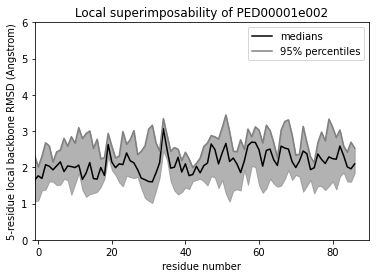

In [69]:
ens_type = "ensemble" # "ensemble" or "random_pool"
data_folder = "ens-dRMS/data/"+ens_type+"/"
ensemble_file = "PED00001e002.pdb"
filename = ensemble_file[0:-4]+"_local_rmsd_5aa.txt"
first_res = -1
last_res = 90

local_superposition(ens_type, data_folder, ensemble_file, first_res, last_res)
plot_local_superposition(filename, ensemble_file, first_res, last_res)